# Examine final data

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
import csv

In [10]:
from colour import Color

plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams['font.size'] = 18
#plt.style.use('dark_background')

orange = Color("orange")

color_objs = list(orange.range_to(Color("slateblue"), 14))
colors = [col.hex for col in color_objs]
len(colors)

14

### Import clients

In [3]:
npzfile0 = np.load('./sber_work_files/final/synt_clients_w_gr_names_ver2.npz', allow_pickle=True)

client_df = npzfile0['client_df']
group_names = npzfile0['group_names']

In [4]:
npzfile1 = np.load('./sber_work_files/final/clients_w_gr_names.npz', allow_pickle=True)

client_df_raw = npzfile1['client_df']

### Import news

In [5]:
npzfile2 = np.load('./sber_work_files/final/news4work.npz', allow_pickle=True)

month_ticks = npzfile2['month_ticks']
month_names = npzfile2['month_names']
fin_top_ts = npzfile2['fin_top_ts']
fin_top_names = npzfile2['fin_top_names']
sorted_topic_names_dict = npzfile2['sorted_topic_names_dict']

### Import context

In [6]:
npzfile3 = np.load('./sber_work_files/final/context_w_labels.npz', allow_pickle=True)

context_ts = npzfile3['context_ts']
context_labels = npzfile3['context_labels']

## Plots

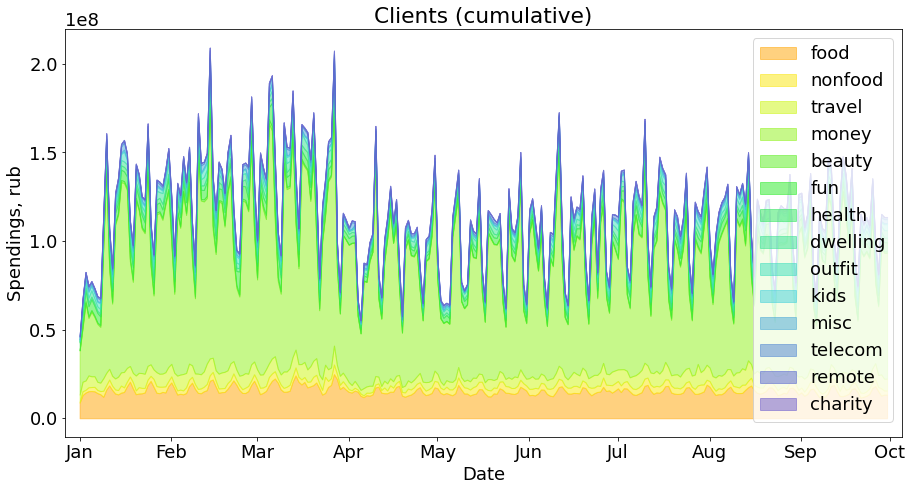

In [12]:
# Cumulative plot for different groups of all clients
client_sum = client_df.sum(axis=0).reshape(len(group_names), client_df.shape[2])

x = np.arange(0, client_df.shape[2])
y = np.zeros(x.shape[0])
stack = [client_sum[n][:] for n in range(len(group_names))]

c = colors

for i, item in enumerate(stack):
    yp = np.copy(y)
    y += item
    plt.fill_between(x, yp, y, color=c[i], alpha=0.5)

plt.title("Clients (cumulative)")
plt.xticks(month_ticks, labels=month_names)
plt.xlim(-5, 278)
plt.ylabel("Spendings, rub")
plt.xlabel("Date")
plt.legend(tuple(group_names))
plt.savefig('./final_pics/clients_cumulative.png', dpi=300)

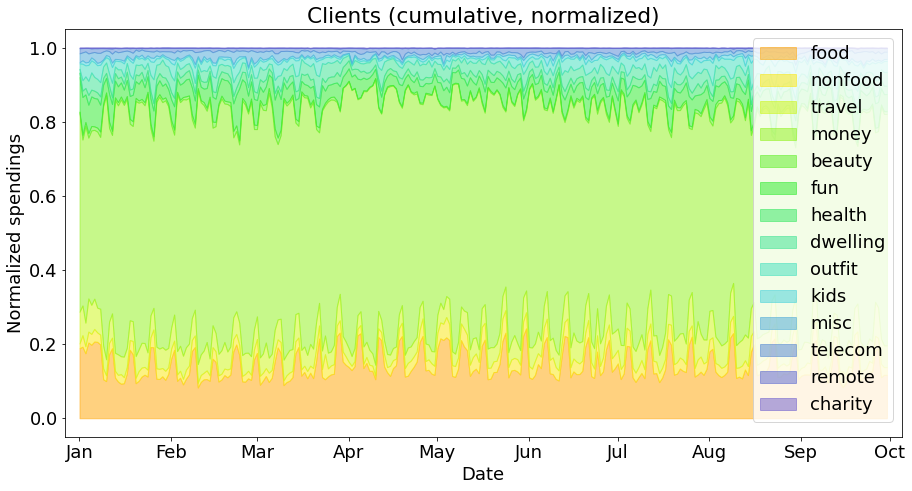

In [13]:
# Normalized cumulative plot for different groups of all clients
client_sum = client_df.sum(axis=0).reshape(len(group_names), client_df.shape[2])
mega_sum = client_sum.sum(axis=0).reshape(client_df.shape[2])

x = np.arange(0, client_df.shape[2])
y = np.zeros(x.shape[0])
stack = [client_sum[n][:] for n in range(len(group_names))]

c = colors

for i, item in enumerate(stack):
    yp = np.copy(y)
    y += item
    plt.fill_between(x, yp/mega_sum, y/mega_sum, color=c[i], alpha=0.5)

plt.title("Clients (cumulative, normalized)")
plt.xticks(month_ticks, labels=month_names)
plt.xlim(-5, 278)
plt.ylabel("Normalized spendings")
plt.xlabel("Date")
plt.legend(tuple(group_names))

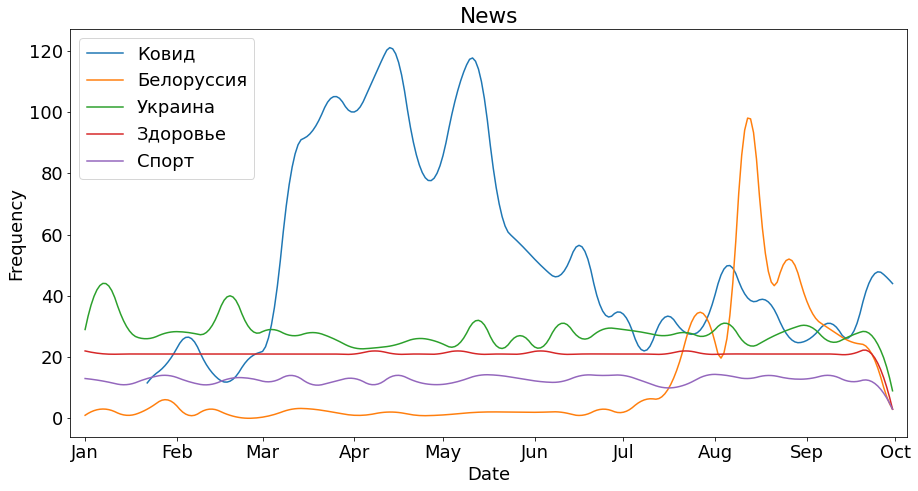

In [18]:
for i in range(5):#fin_top_ts.shape[0]):
    lbl = fin_top_names[i]
    plt.plot(fin_top_ts[i], label=lbl)
    plt.title("News")
    plt.xticks(month_ticks, labels=month_names)
    plt.xlim(-5, 278)
    plt.ylabel("Frequency")
    plt.xlabel("Date")

plt.legend()#prop={'size': 8})

Text(0.5, 0, 'Date')

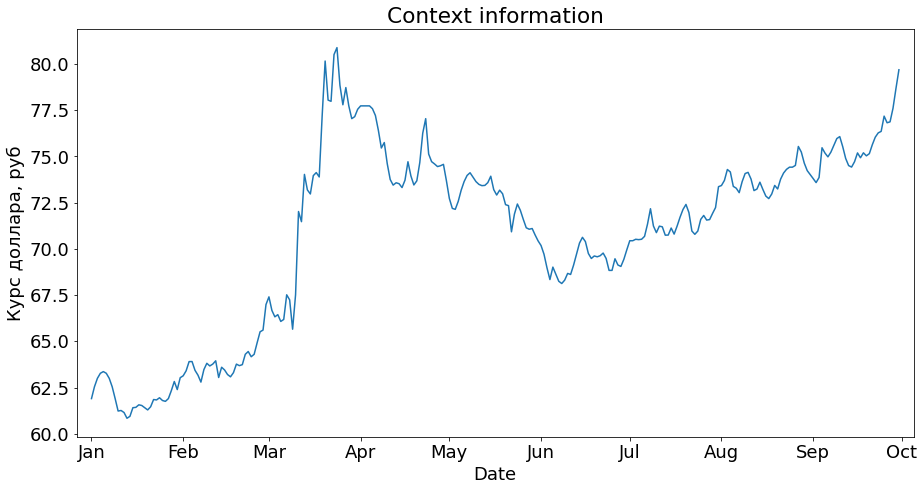

In [19]:
num = 4
plt.plot(context_ts[num])
plt.title("Context information")
plt.xticks(month_ticks, labels=month_names)
plt.xlim(-5, 278)
plt.ylabel(context_labels[num])
plt.xlabel("Date")

## Autocorrelation in client dataset

In [20]:
#from influxdb import InfluxDBClient
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress

Text(0.5, 0, 'Date')

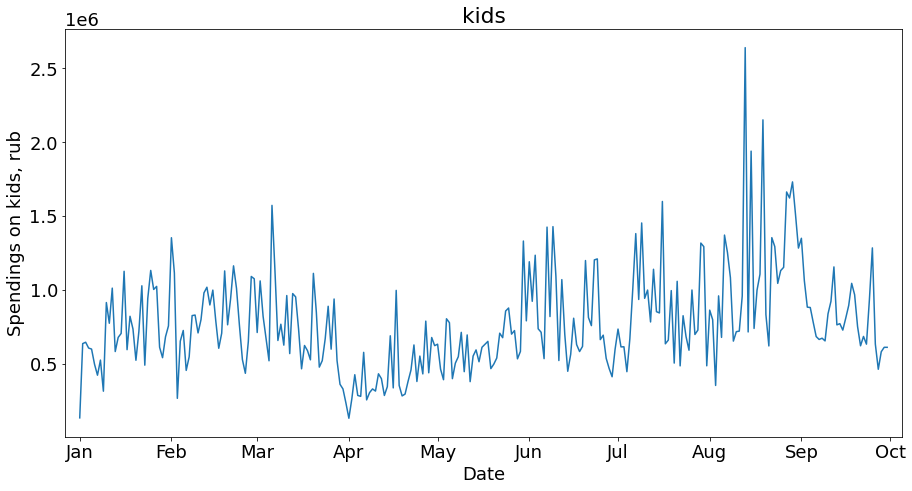

In [21]:
cat = np.random.randint(0, len(group_names))
client_sum = client_df.sum(axis=0).reshape(len(group_names), client_df.shape[2])

plt.plot(client_sum[cat])
plt.title(group_names[cat])
plt.xticks(month_ticks, labels=month_names)
plt.xlim(-5, 278)
plt.ylabel(f"Spendings on {group_names[cat]}, rub")
plt.xlabel("Date")

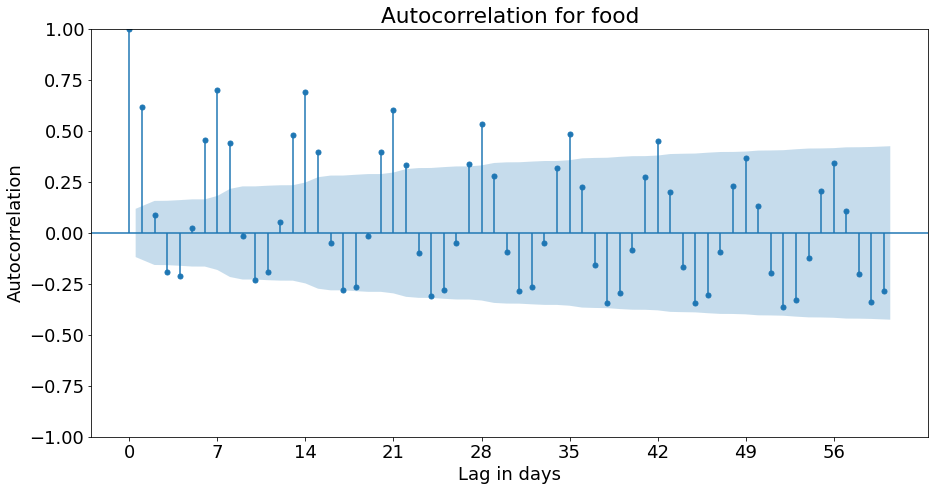

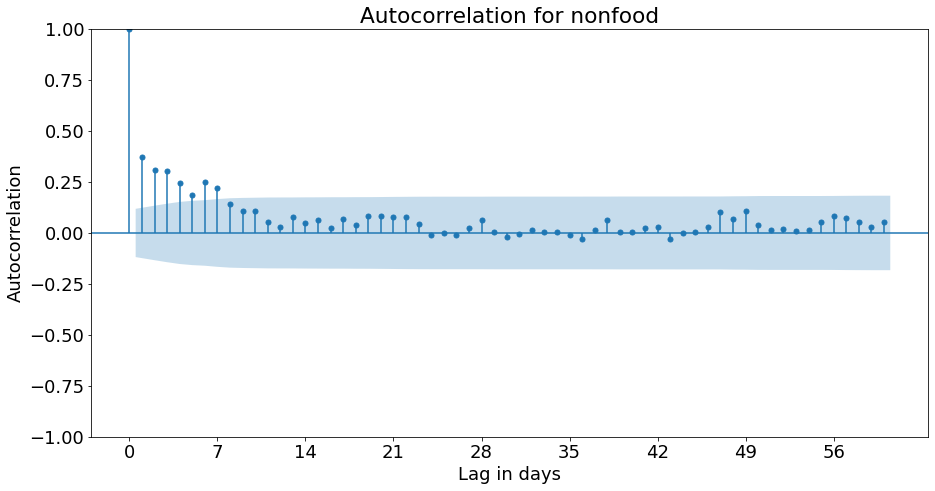

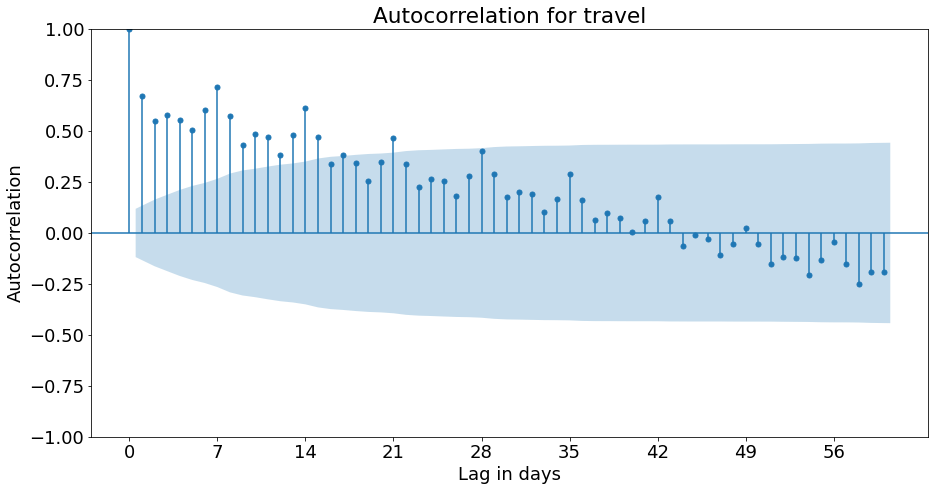

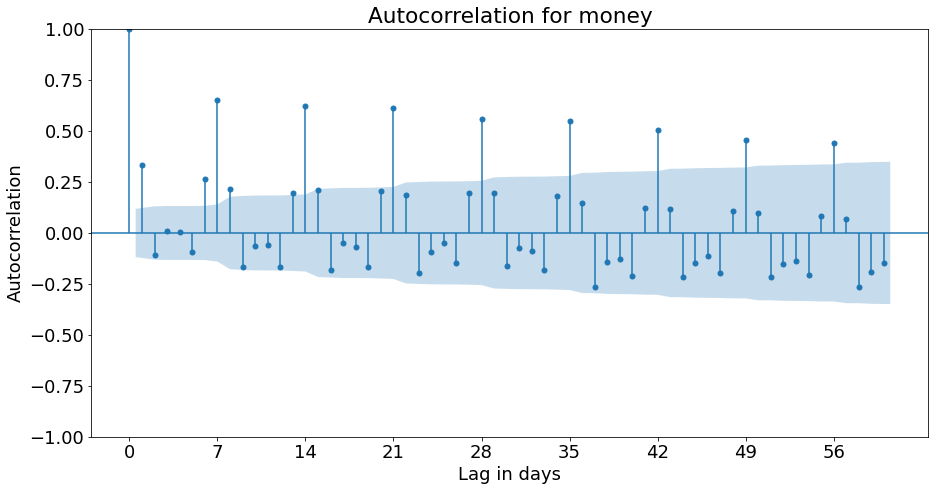

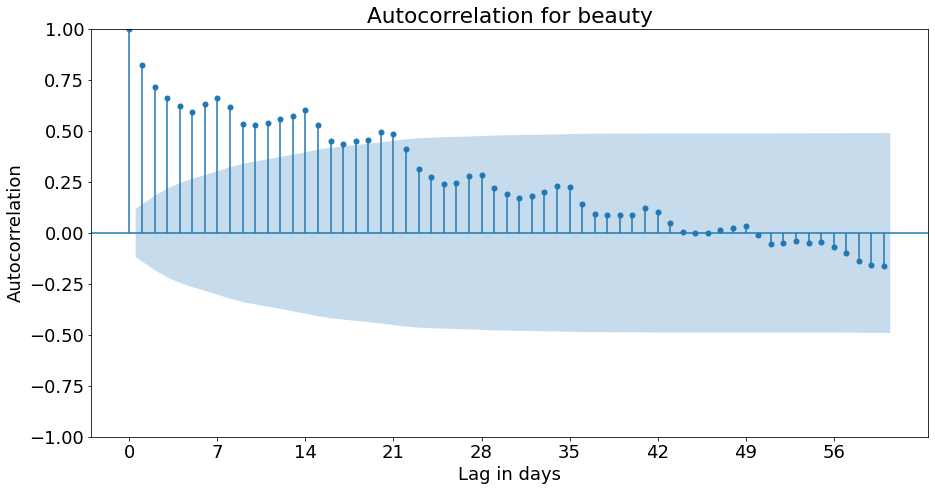

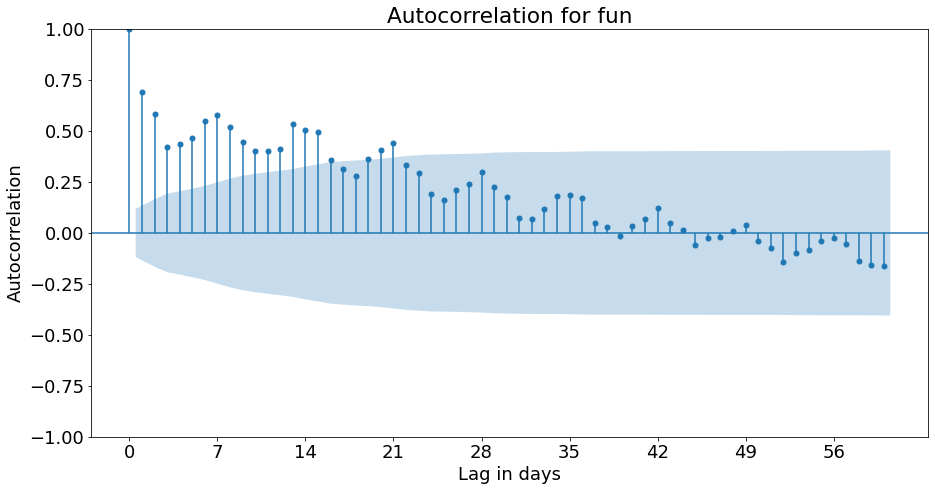

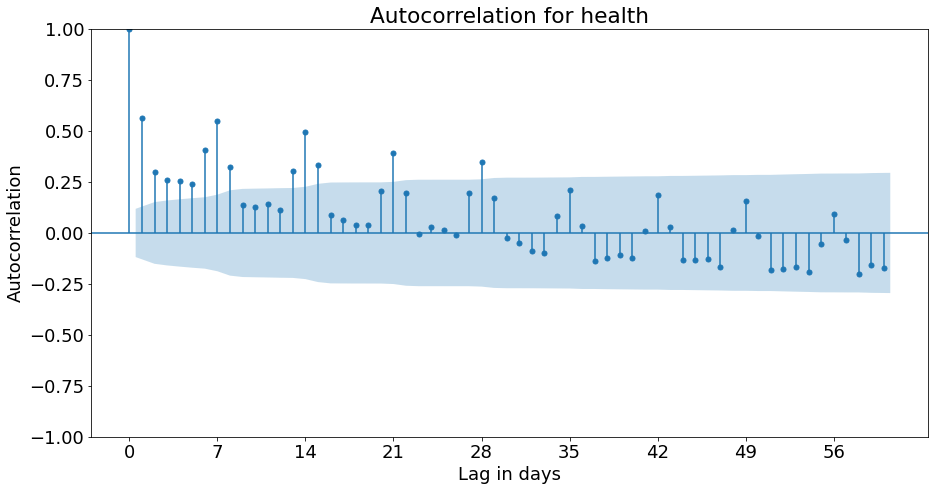

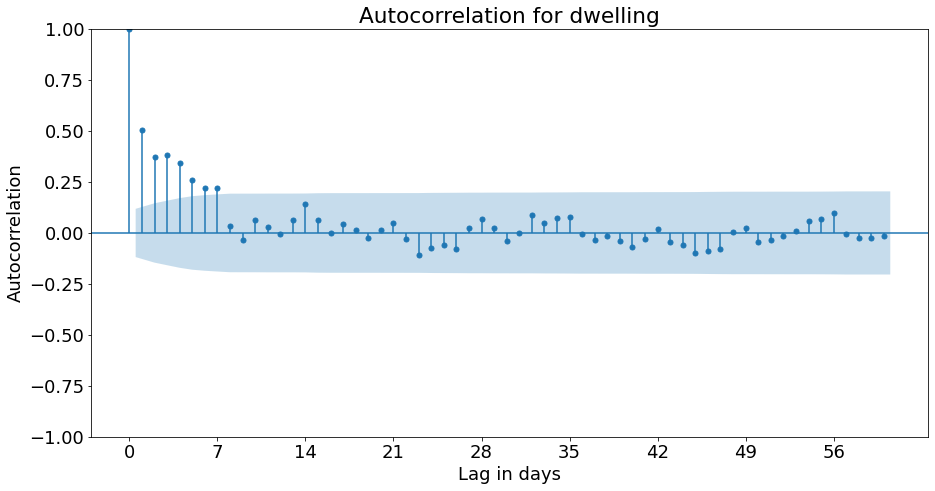

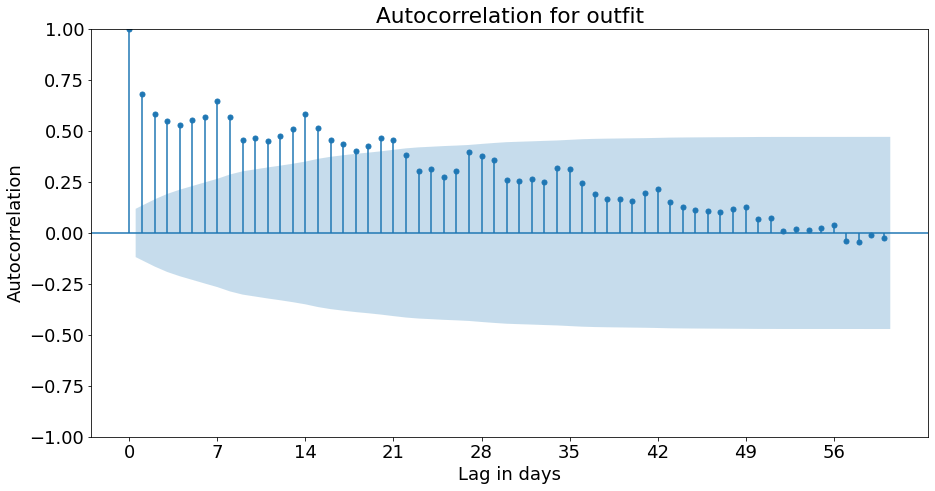

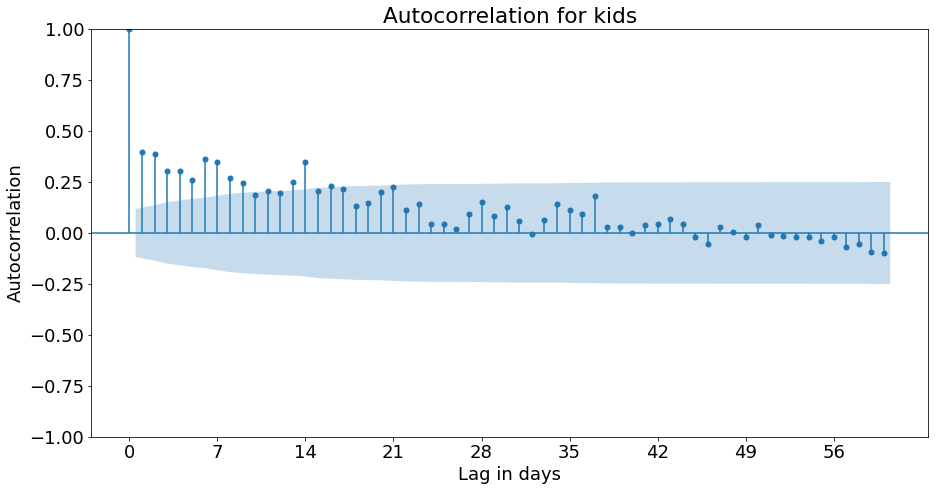

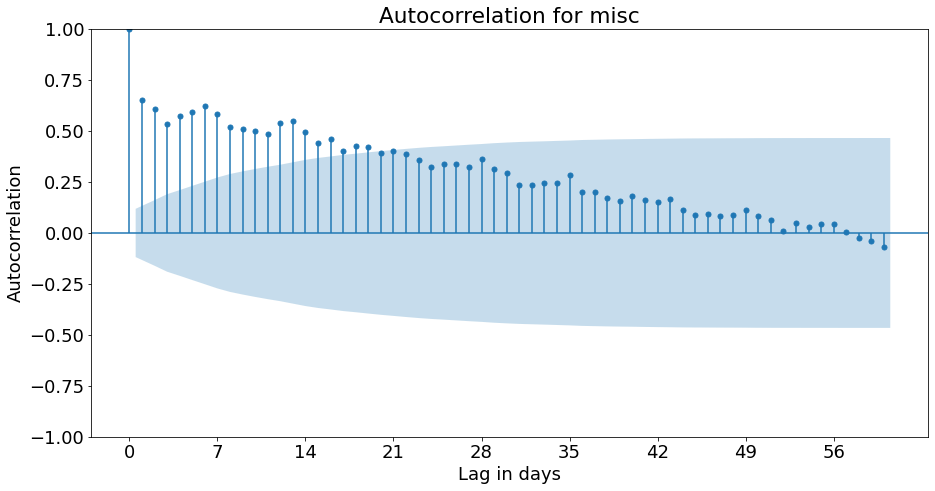

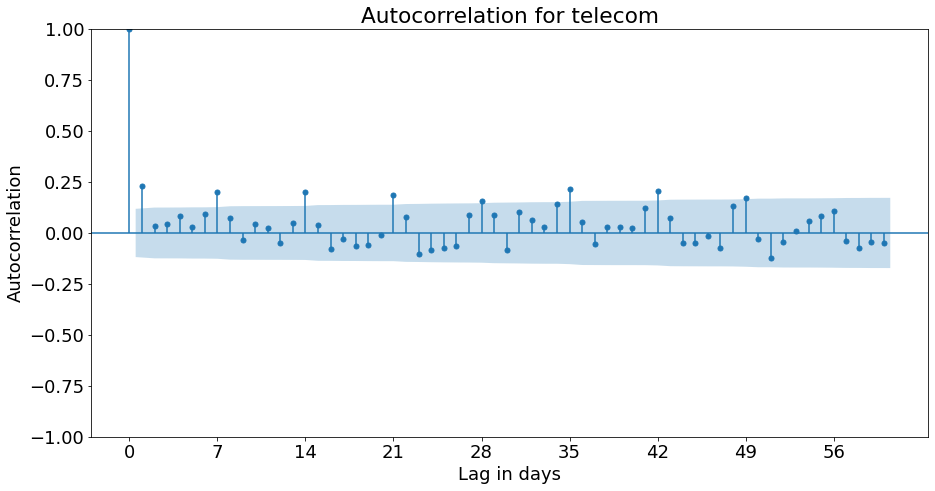

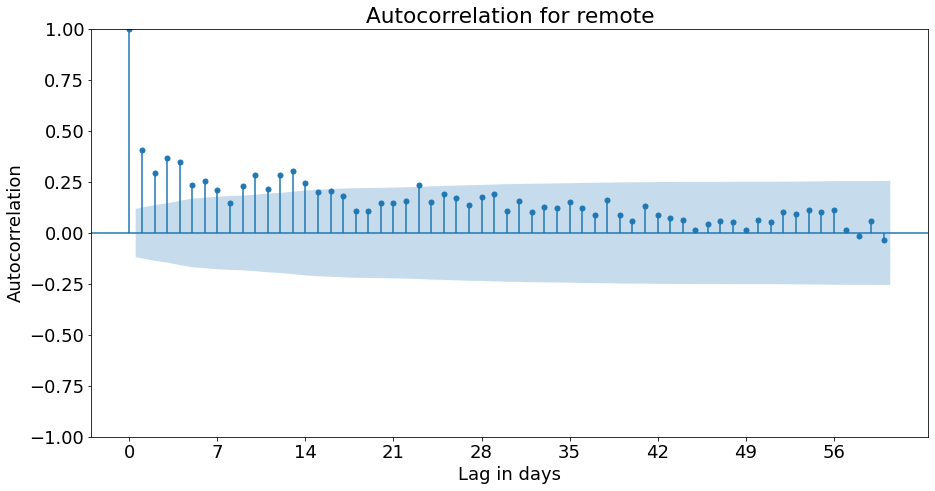

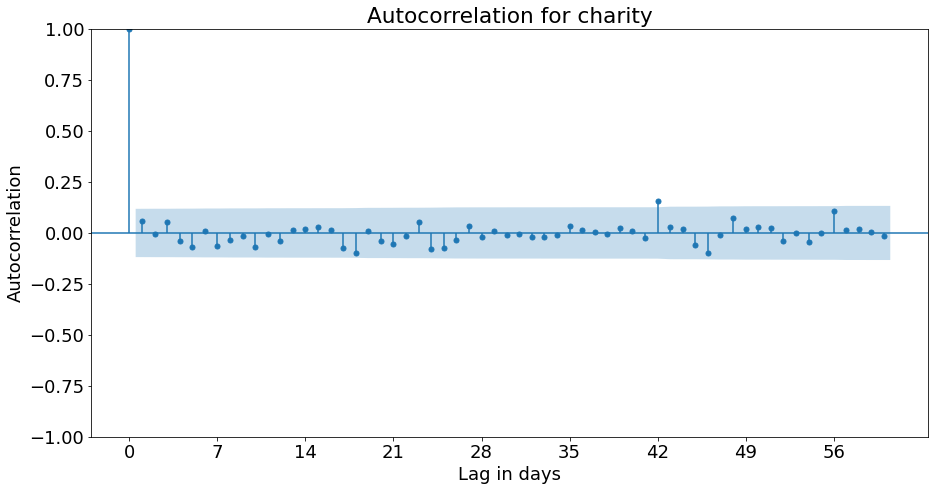

In [22]:
client_sum = client_df.sum(axis=0).reshape(len(group_names), client_df.shape[2])

for i, name in enumerate(group_names):
    num_lags = 60
    plot_acf(client_sum[i], lags=num_lags)
    plt.title(f"Autocorrelation for {name}")
    plt.ylabel("Autocorrelation")
    plt.xlabel("Lag in days")
    plt.xticks(np.arange(0, num_lags, 7))
    plt.show

In [23]:
client_df.shape

(15000, 14, 274)

# Compare synthetic and raw client data

In [24]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    
    Returns
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

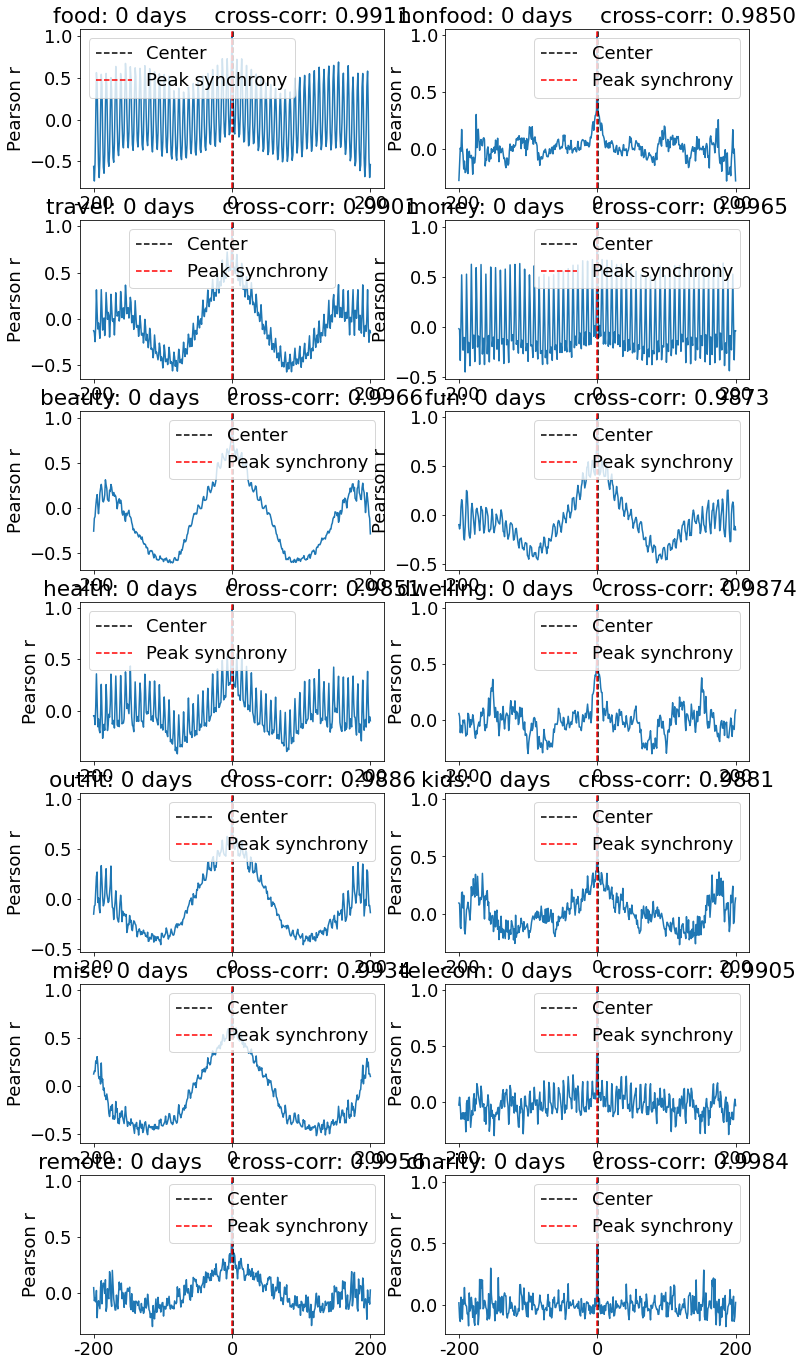

In [25]:
cli1 = client_df.sum(axis=0)
cli2 = client_df_raw.sum(axis=0)

plt.rcParams["figure.figsize"] = (12, 24)
max_lag = 200

for num in range(14):
    t1 = cli1[num,:]
    t2 = cli2[num,:]
    data = np.array([t1, t2])
    temp_df = pd.DataFrame(data=data.T, columns=['t1', 't2'])
    
    t1 = temp_df['t1']
    t2 = temp_df['t2']
    
    plt.subplot(7, 2, num+1)
    rs = [crosscorr(t1, t2, lag) for lag in range(-int(max_lag),int(max_lag+1))]
    ans = float(crosscorr(t1, t2, 0))
    offset = np.floor(len(rs)/2)-np.argmax(rs)

    plt.plot(rs)
    plt.axvline(np.ceil(len(rs)/2), color='k', linestyle='--', label='Center')
    plt.axvline(np.argmax(rs), color='r', linestyle='--', label='Peak synchrony')
    plt.title(f"{group_names[num]}: {int(offset)} days    cross-corr: {ans:.4f}")
    #plt.xlabel('Offset')
    plt.ylabel('Pearson r')
    plt.xticks(list(range(0, 1401, 200)), labels=[i-max_lag for i in list(range(0, 1401, 200))])
    plt.xlim(right=(max_lag*2+20))
    plt.legend()

plt.rcParams["figure.figsize"] = (12, 8)